In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.stats import linregress
import yaml
sns.set()

In [17]:
configs_dir = os.path.join(os.getcwd(), '..', '..', 'configs', 'resident')
extrapolation_yaml_file = os.path.join(os.getcwd(), 'av_extrapolation.yaml')
vehicle_type_data_file = os.path.join(configs_dir, 'vehicle_type_data.csv')

assert os.path.isdir(configs_dir), f"The folder {configs_dir} does not exist"
assert os.path.isfile(extrapolation_yaml_file), f"The file {extrapolation_yaml_file} does not exist"
assert os.path.isfile(vehicle_type_data_file), f"The file {vehicle_type_data_file} does not exist"

In [18]:
def linear_extrapolation(x, y, x_pred):
    xy_dict = dict(zip(x,y))
    res = linregress(x, y)
    y_pred = []

    for year in x_pred:
        if year in xy_dict.keys():
            y_pred.append(xy_dict[year])
        else:
            pred = res.intercept + res.slope * year
            if pred < 0:
                pred = 0
            y_pred.append(pred)

    return y_pred


def average_extrapolation(x, y, x_pred):
    y_mean = y.sum() / (x.max() - x.min())
    y_pred = []
    xy_dict = dict(zip(x, y))
    for x in x_pred:
        if x in xy_dict.keys():
            y_pred.append(xy_dict[x])
        else:
            y_pred.append(y_mean) 
    return y_pred

def annual_percent_change(x, y, x_pred, per_change, start_value):
    y_pred = []
    xy_dict = dict(zip(x, y))

    if start_value == None:
        assert len(y) > 0, "No existing values, need to supply start value"
        # starting setting start value as y_mean
        start_value = y.sum() / (x.max() - x.min())
    
    def percent_change(start_value, years, per_change):
        return start_value * (1 + per_change)**years

    for x in x_pred:
        if x in xy_dict.keys():
            y_pred.append(xy_dict[x])
        else:
            years = x - x_pred.min()
            y_pred.append(percent_change(start_value, years, per_change)) 
    return y_pred


def assert_constant(x, y, x_pred, constant):
    y_pred = []
    xy_dict = dict(zip(x, y))

    for x in x_pred:
        if x in xy_dict.keys():
            y_pred.append(xy_dict[x])
        else:
            years = x - x_pred.min()
            y_pred.append(constant) 
    return y_pred


def assert_future_year_values(x, y, x_pred, asserted_years, asserted_values):
    y_pred = []
    xy_dict = dict(zip(x,y))

    # creating lists
    if not isinstance(asserted_years, list):
        asserted_years = [asserted_years]
    if not isinstance(asserted_values, list):
        asserted_values = [asserted_values]

    assert len(asserted_years) == len(asserted_values), "Asserted years and values do not have the same length"

    if len(asserted_years) == 1:
        # just gave final year, using last known year values as start of line
        asserted_years = [x[0]] + asserted_years
        asserted_values = [y[0]] + asserted_values

    for i in range(len(asserted_years)):
        if asserted_years[i] not in x_pred:
            asserted_years = asserted_years.pop(i)
            asserted_values = asserted_values.pop(i)

    # linear interpolation of asserted values
    fit = pd.Series(index=x_pred, dtype='float64')
    fit.loc[x] = y
    fit.loc[asserted_years] = asserted_values
    fit = fit.interpolate(method='linear', limit_direction='both').clip(lower=0)

    xy_asserted_dict = fit.to_dict()

    for year in x_pred:
        if year in xy_dict.keys():
            y_pred.append(xy_dict[year])
        elif year in xy_asserted_dict.keys():
            y_pred.append(xy_asserted_dict[year])

    return y_pred


In [19]:
def extrapolate_vehicle_type_data(vehicle_type_data_file, extrapolation_yaml_file):

    veh_data = pd.read_csv(vehicle_type_data_file)
    with open(extrapolation_yaml_file) as f:
        ext_settings = yaml.load(f, Loader=yaml.SafeLoader)

    min_fit_year = ext_settings['min_fit_year']
    max_extension = ext_settings['max_extension']
    body_types = ext_settings['body_types']
    fuel_types = ext_settings['fuel_types']

    ext_veh_type_data = []

    # looping through all variables
    for var in ext_settings['variables_to_extrapolate']:
        print("Extrapolating Variable:", var)
        var_ext_settings = ext_settings.get(var, {})
        dfs = []
        excluded_alts = []

        plt.figure(figsize=(25,15))
        for b_num, body_type in enumerate(body_types):
            # making figure for each body type
            plt.subplot(3, 3, b_num+1)
            plt.title(f'{var}: {body_type}')

            for f_num, fuel_type in enumerate(fuel_types):
                # grabbing extrapolation settings for this data
                body_fuel = body_type + '_' + fuel_type
                subset_settings = var_ext_settings.get(body_fuel, {})
                subset = veh_data[(veh_data.body_type == body_type) & (veh_data.fuel_type == fuel_type)]

                if (len(subset) == 0) & (len(subset_settings) == 0):
                    excluded_alts.append(body_fuel)
                    continue
                
                if len(subset) > 0 :
                    sns.lineplot(x=subset.vehicle_year, y=subset[var], color=sns.color_palette()[f_num])

                ext_method = subset_settings.get('method', 'average')
                
                x = subset[subset.vehicle_year >= min_fit_year]['vehicle_year'].values
                y = subset[subset.vehicle_year >= min_fit_year][var].values
                x_pred = np.array(range(min_fit_year, max_extension + 1))

                if ext_method == 'linear':
                    y_pred = linear_extrapolation(x, y, x_pred)
                elif ext_method == 'average':
                    y_pred = average_extrapolation(x, y, x_pred)
                elif ext_method == 'percentage_change':
                    y_pred = annual_percent_change(x, y, x_pred, subset_settings['annual_per_change'], subset_settings.get('start_value', None))
                elif ext_method == 'assert_constant':
                    y_pred = assert_constant(x, y, x_pred, subset_settings['value'])
                elif ext_method == 'assert_values':
                    y_pred = assert_future_year_values(x, y, x_pred, subset_settings['years'], subset_settings['values'])
                else:
                    raise RuntimeError(f"method {ext_method} is not recognized for {body_fuel}.")


                # plot accompanying fit
                sns.lineplot(x=x_pred, y=y_pred, label=f'{fuel_type}', color=sns.color_palette()[f_num], linestyle='--')
                # creating a mini df for each body type and fuel type combo
                df = pd.DataFrame(data={
                    'body_type': body_type,
                    'fuel_type': fuel_type,
                    'vehicle_year': x_pred,
                    var: y_pred})
                dfs.append(df)

        plt.show()
        print(f"{var} for the following alternatives will be set to 0 for all years:\n {excluded_alts}")
        ext_veh_type_data.append(pd.concat(dfs).set_index(['body_type', 'fuel_type', 'vehicle_year']))


    ext_veh_type_data = pd.concat(ext_veh_type_data, axis=1)
    ext_veh_type_data = ext_veh_type_data.loc[:,~ext_veh_type_data.columns.duplicated()].copy().fillna(0)
    return veh_data, ext_veh_type_data


In [26]:
old_veh_data.set_index(['body_type', 'fuel_type', 'vehicle_year']).combine_first(ext_veh_type_data)

MPG      NewPrice  NumMakes  \
body_type fuel_type vehicle_year                                      
Car       BEV       1998           0.000000   44331.89559       0.0   
                    1999           0.000000   44331.89559       0.0   
                    2000           0.000000   44331.89559       0.0   
                    2001           0.000000   44331.89559       0.0   
                    2002           0.000000   44331.89559       0.0   
...                                     ...           ...       ...   
Van-AV    PEV       2046          51.274186  800000.00000       2.6   
                    2047          52.043299  800000.00000       2.7   
                    2048          52.823948  800000.00000       2.8   
                    2049          53.616308  800000.00000       2.9   
                    2050          54.420552  800000.00000       3.0   

                                  NumModels  Range  auto_operating_cost  \
body_type fuel_type vehicle_year                                          
Car       BEV       1998               0.00    0.0            10.868294   
                    1999               0.00    0.0            10.868294   
                    2000               0.00    0.0            10.868294   
                    2001               0.00    0.0            10.868294   
                    2002               0.00    0.0            10.868294   
...                                     ...    ...                  ...   
Van-AV    PEV       2046               3.40    0.0            17.000000   
                    2047               3.55    0.0            17.000000   
                    2048               3.70    0.0            17.000000   
                    2049               3.85    0.0            17.000000   
                    2050               4.00    0.0            17.000000   

                                  co2gpm  
body_type fuel_type vehicle_year          
Car       BEV       1998             0.0  
                    1999             0.0  
                    2000             0.0  
                    2001             0.0  
                    2002             0.0  
...                                  ...  
Van-AV    PEV       2046             NaN  
                    2047             NaN  
                    2048             NaN  
                    2049             NaN  
                    2050             NaN  

[1653 rows x 7 columns]

Extrapolating Variable: NumMakes


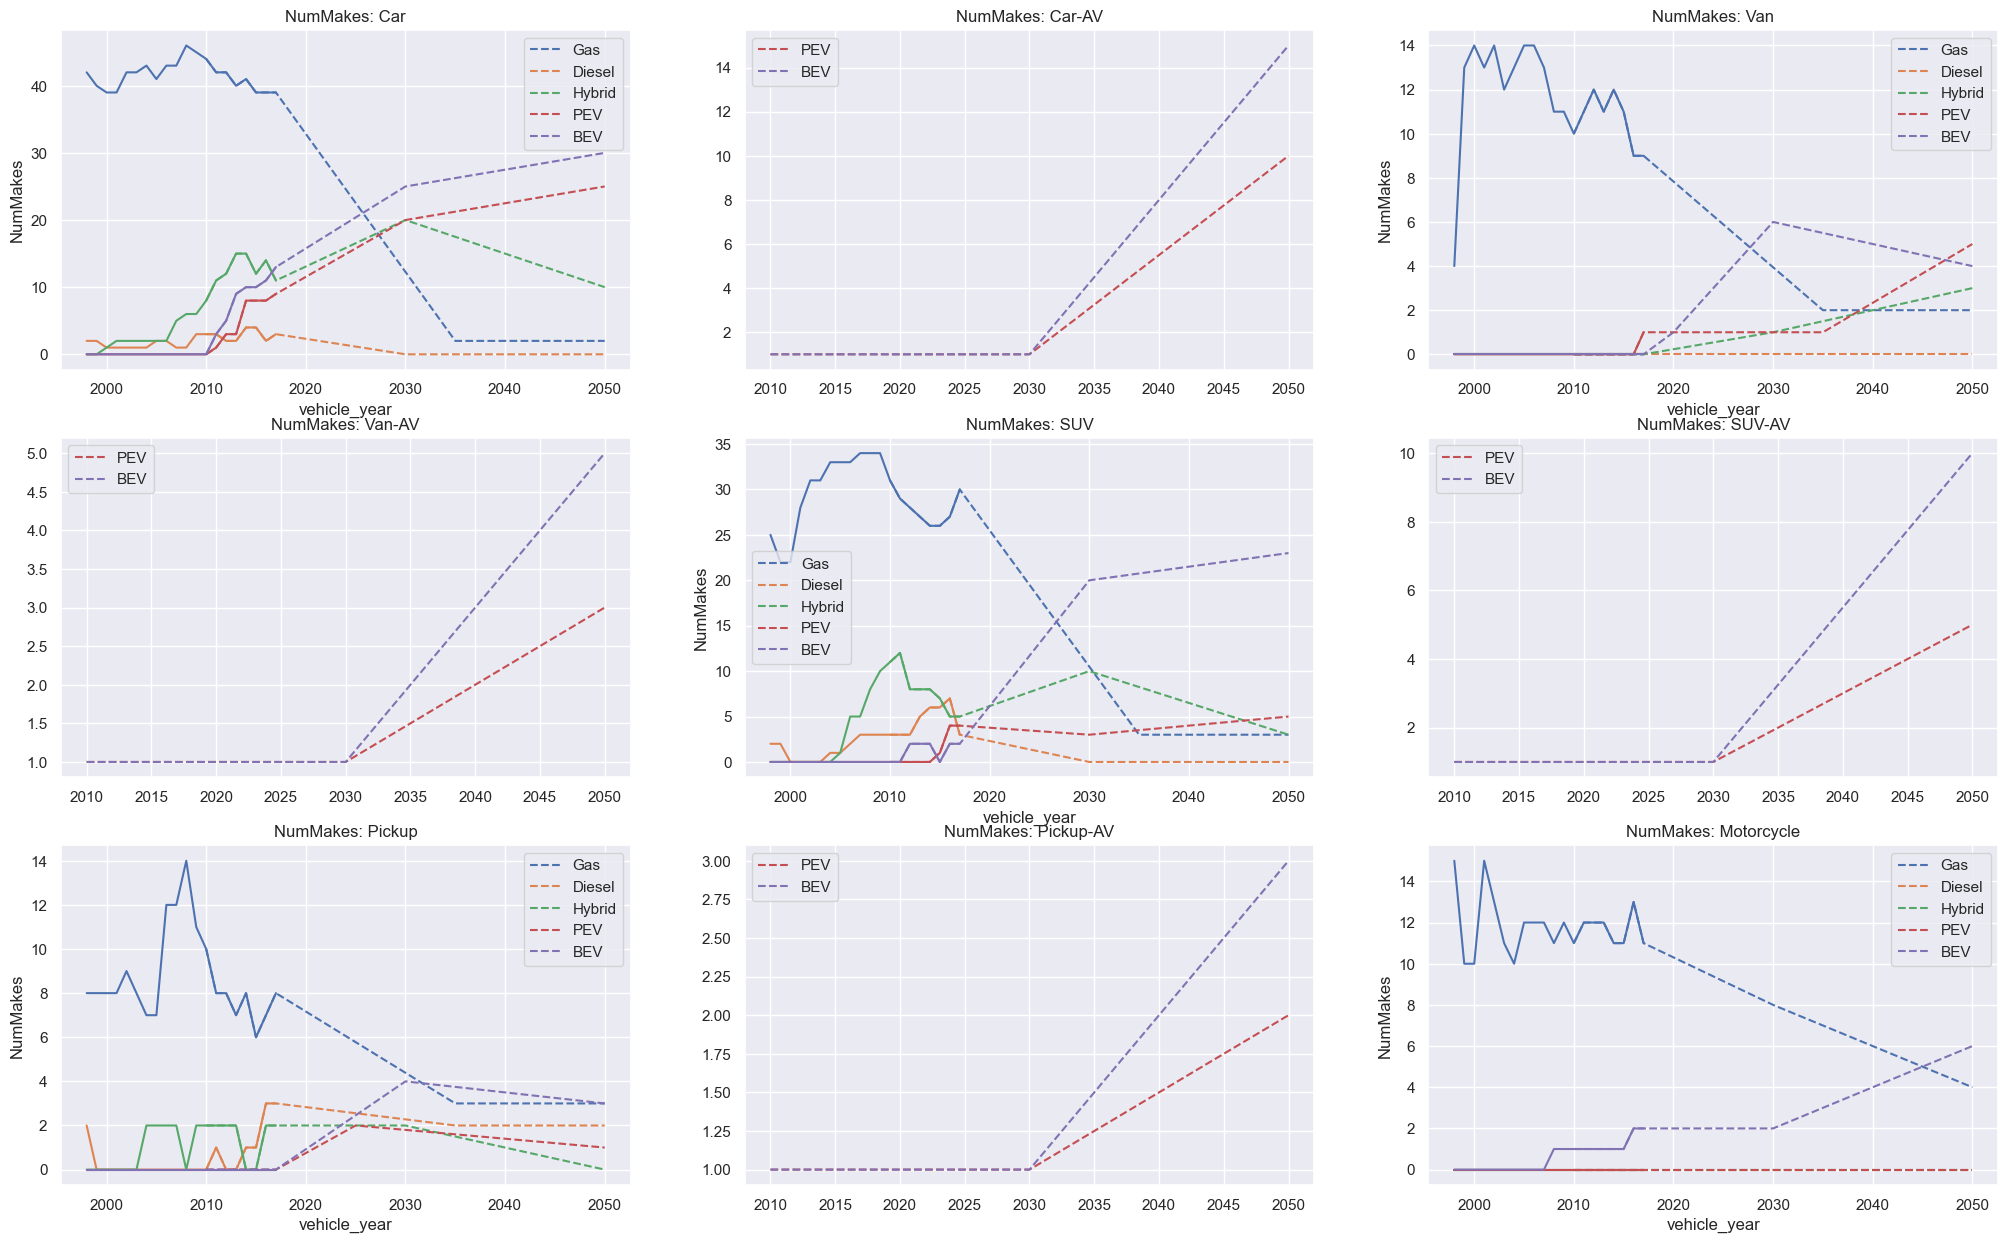

NumMakes for the following alternatives will be set to 0 for all years:
 ['Car-AV_Gas', 'Car-AV_Diesel', 'Car-AV_Hybrid', 'Van-AV_Gas', 'Van-AV_Diesel', 'Van-AV_Hybrid', 'SUV-AV_Gas', 'SUV-AV_Diesel', 'SUV-AV_Hybrid', 'Pickup-AV_Gas', 'Pickup-AV_Diesel', 'Pickup-AV_Hybrid']
Extrapolating Variable: NumModels


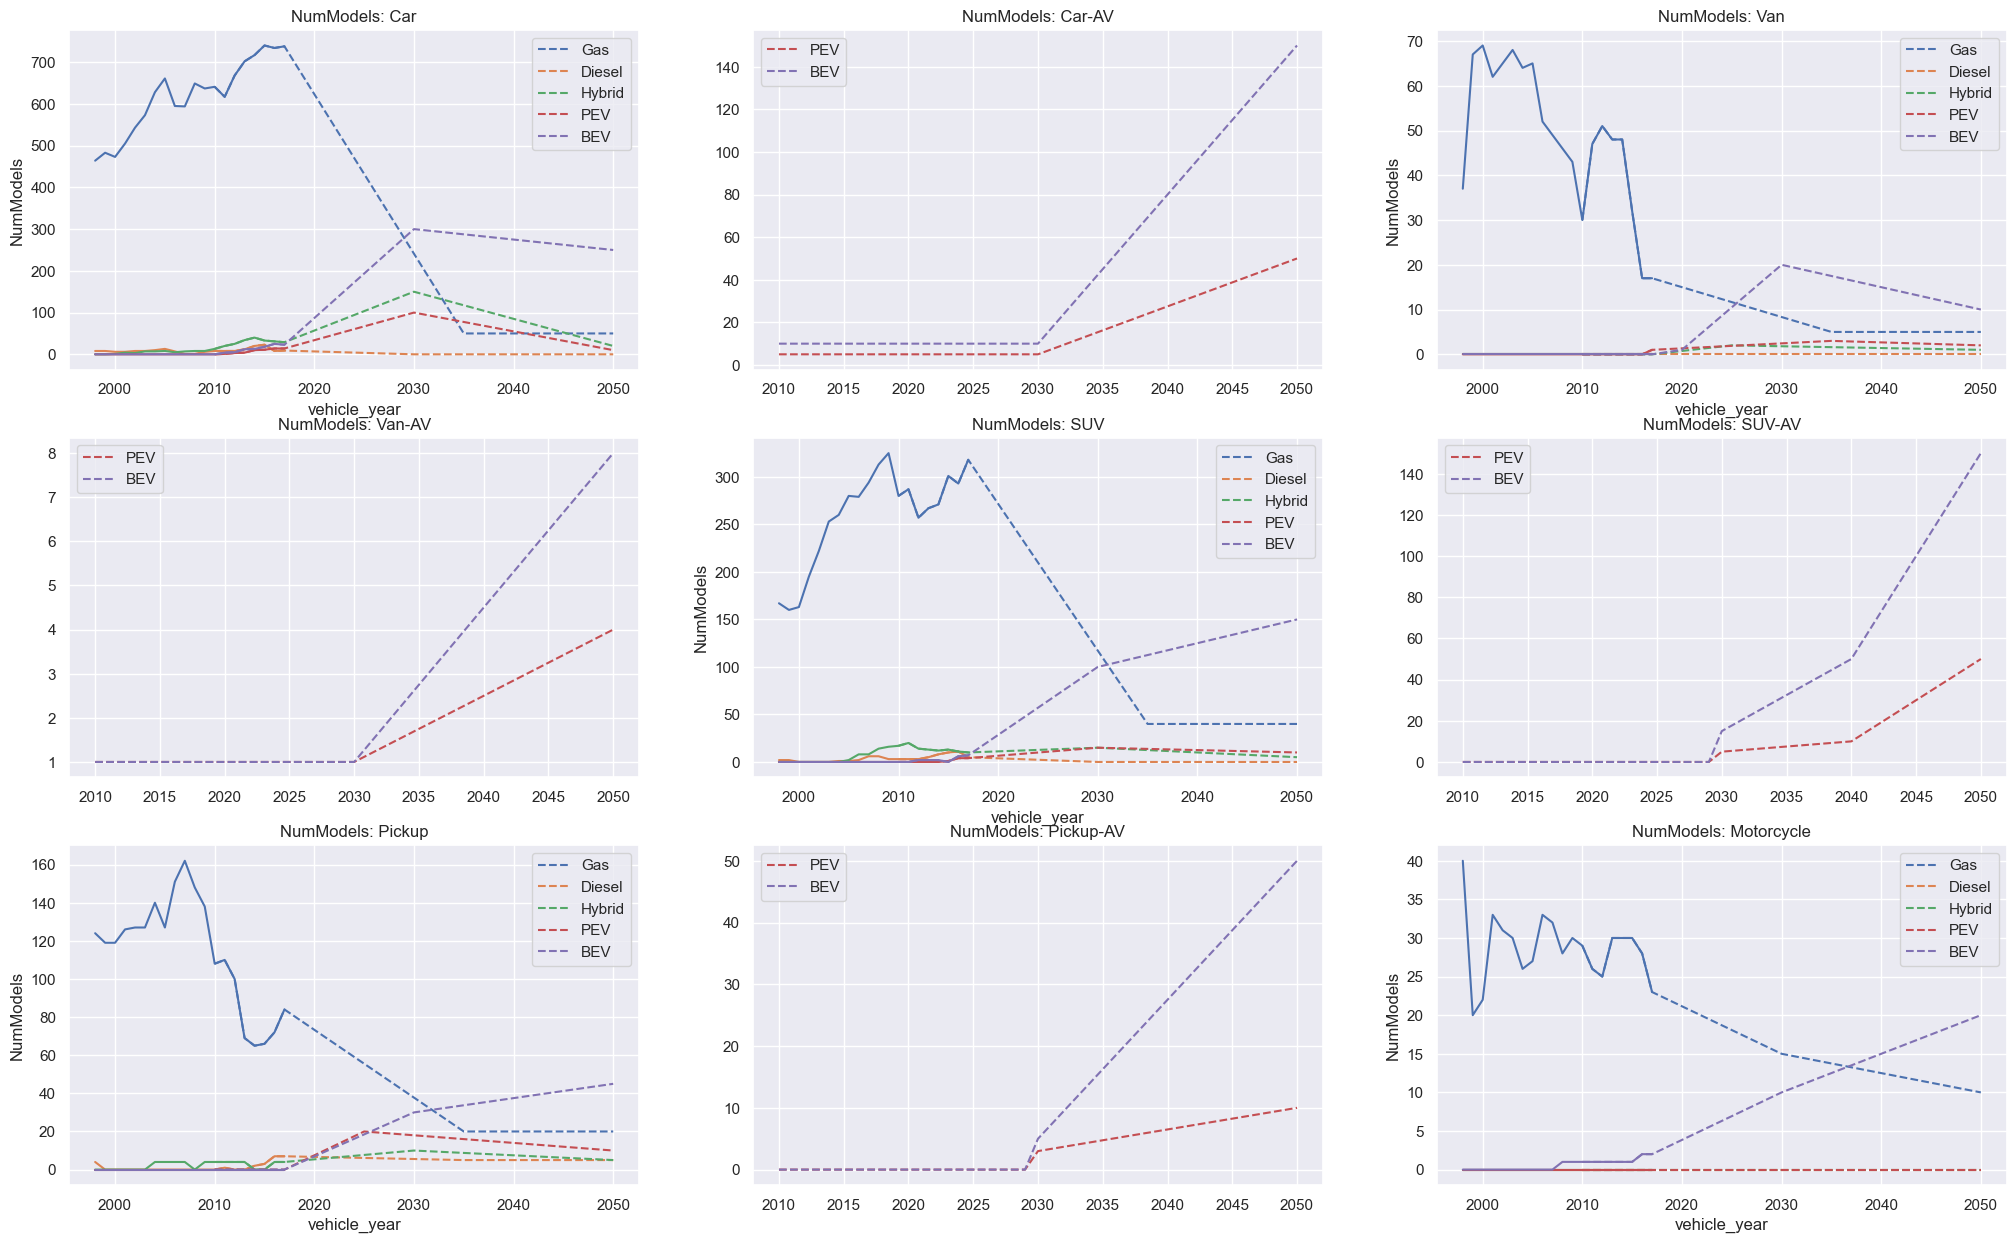

NumModels for the following alternatives will be set to 0 for all years:
 ['Car-AV_Gas', 'Car-AV_Diesel', 'Car-AV_Hybrid', 'Van-AV_Gas', 'Van-AV_Diesel', 'Van-AV_Hybrid', 'SUV-AV_Gas', 'SUV-AV_Diesel', 'SUV-AV_Hybrid', 'Pickup-AV_Gas', 'Pickup-AV_Diesel', 'Pickup-AV_Hybrid']
Extrapolating Variable: MPG


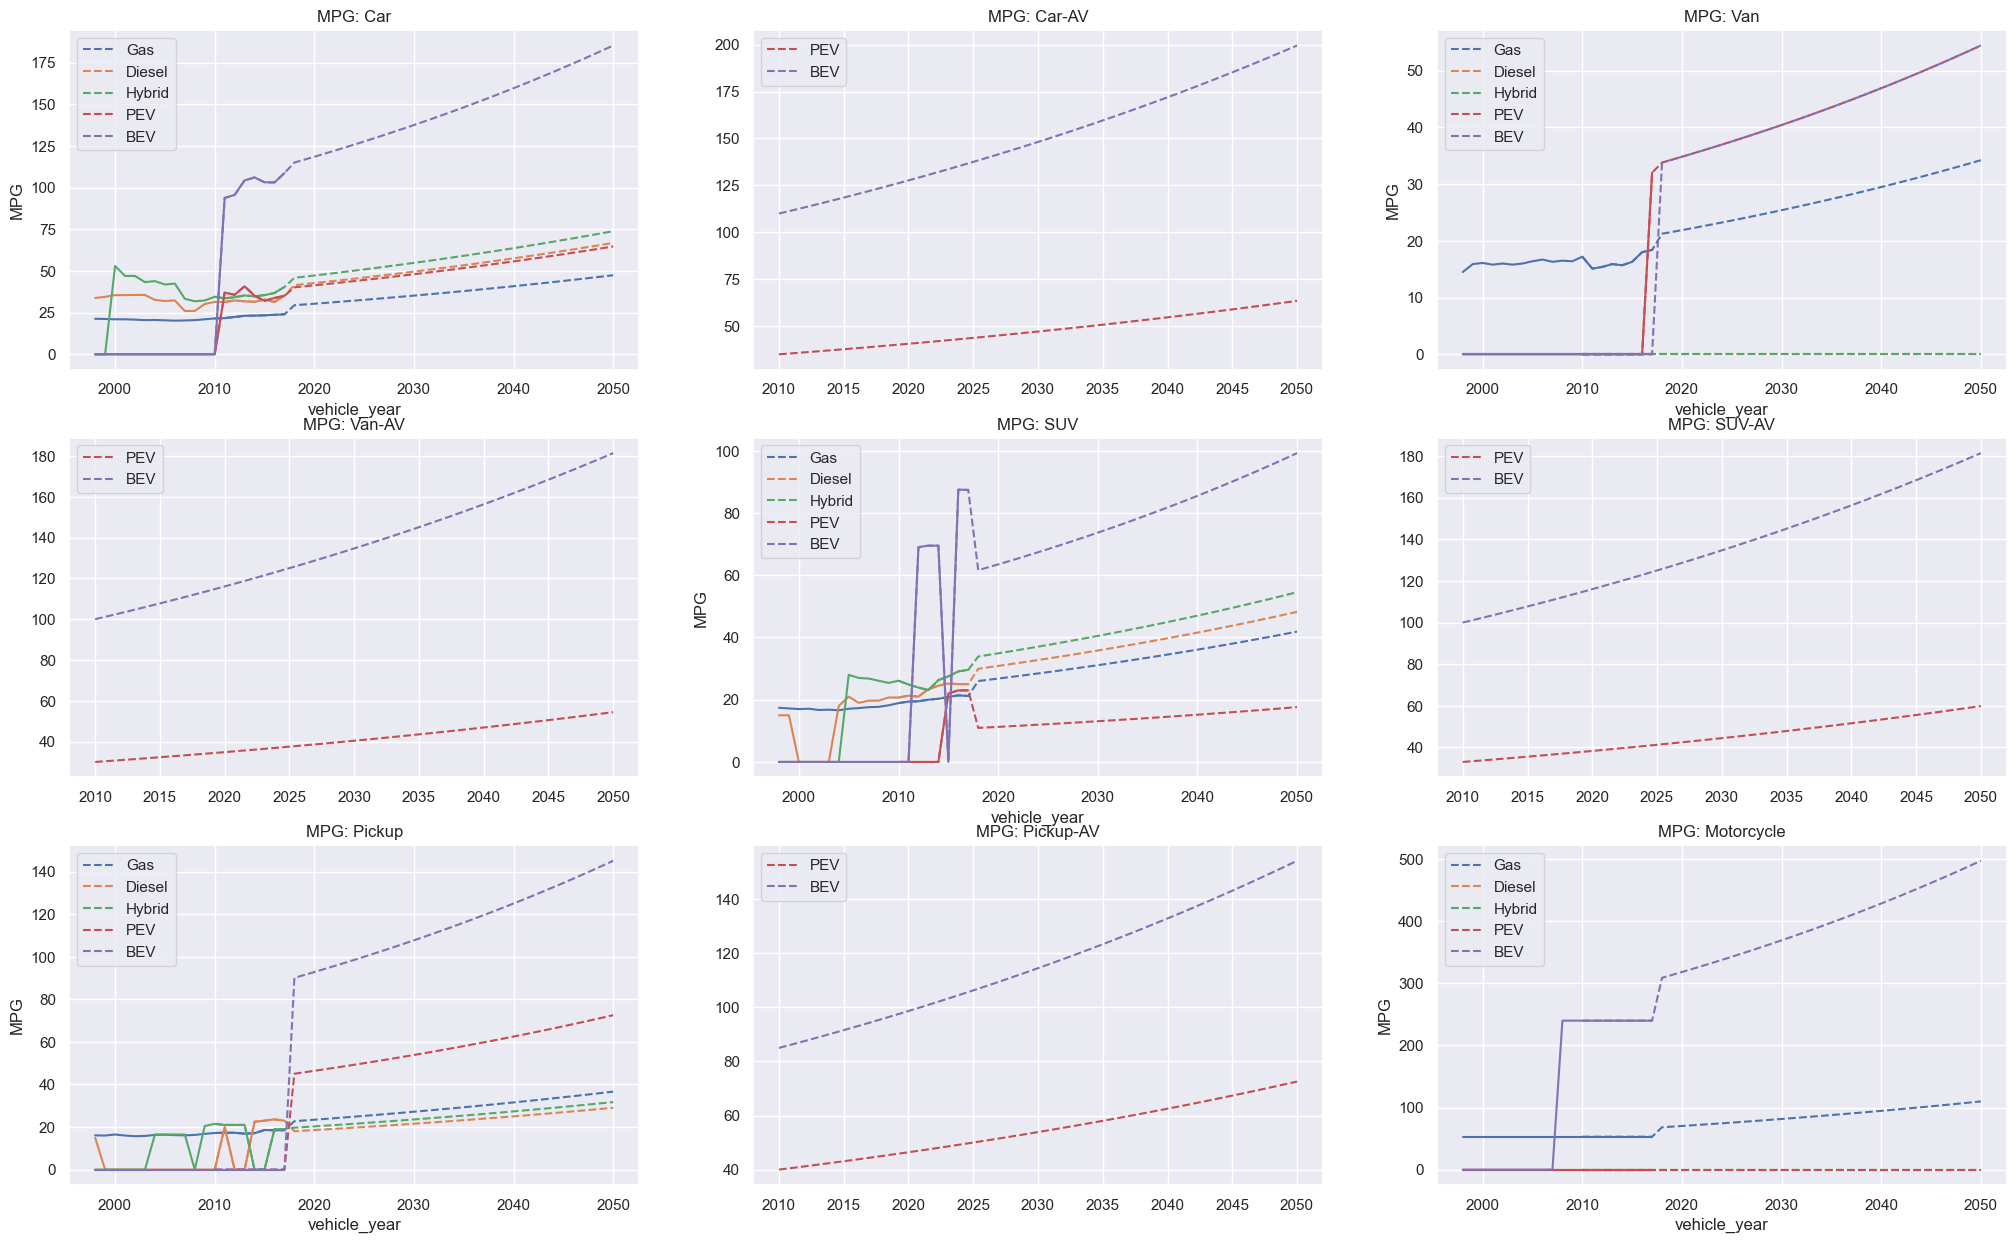

MPG for the following alternatives will be set to 0 for all years:
 ['Car-AV_Gas', 'Car-AV_Diesel', 'Car-AV_Hybrid', 'Van-AV_Gas', 'Van-AV_Diesel', 'Van-AV_Hybrid', 'SUV-AV_Gas', 'SUV-AV_Diesel', 'SUV-AV_Hybrid', 'Pickup-AV_Gas', 'Pickup-AV_Diesel', 'Pickup-AV_Hybrid']
Extrapolating Variable: Range


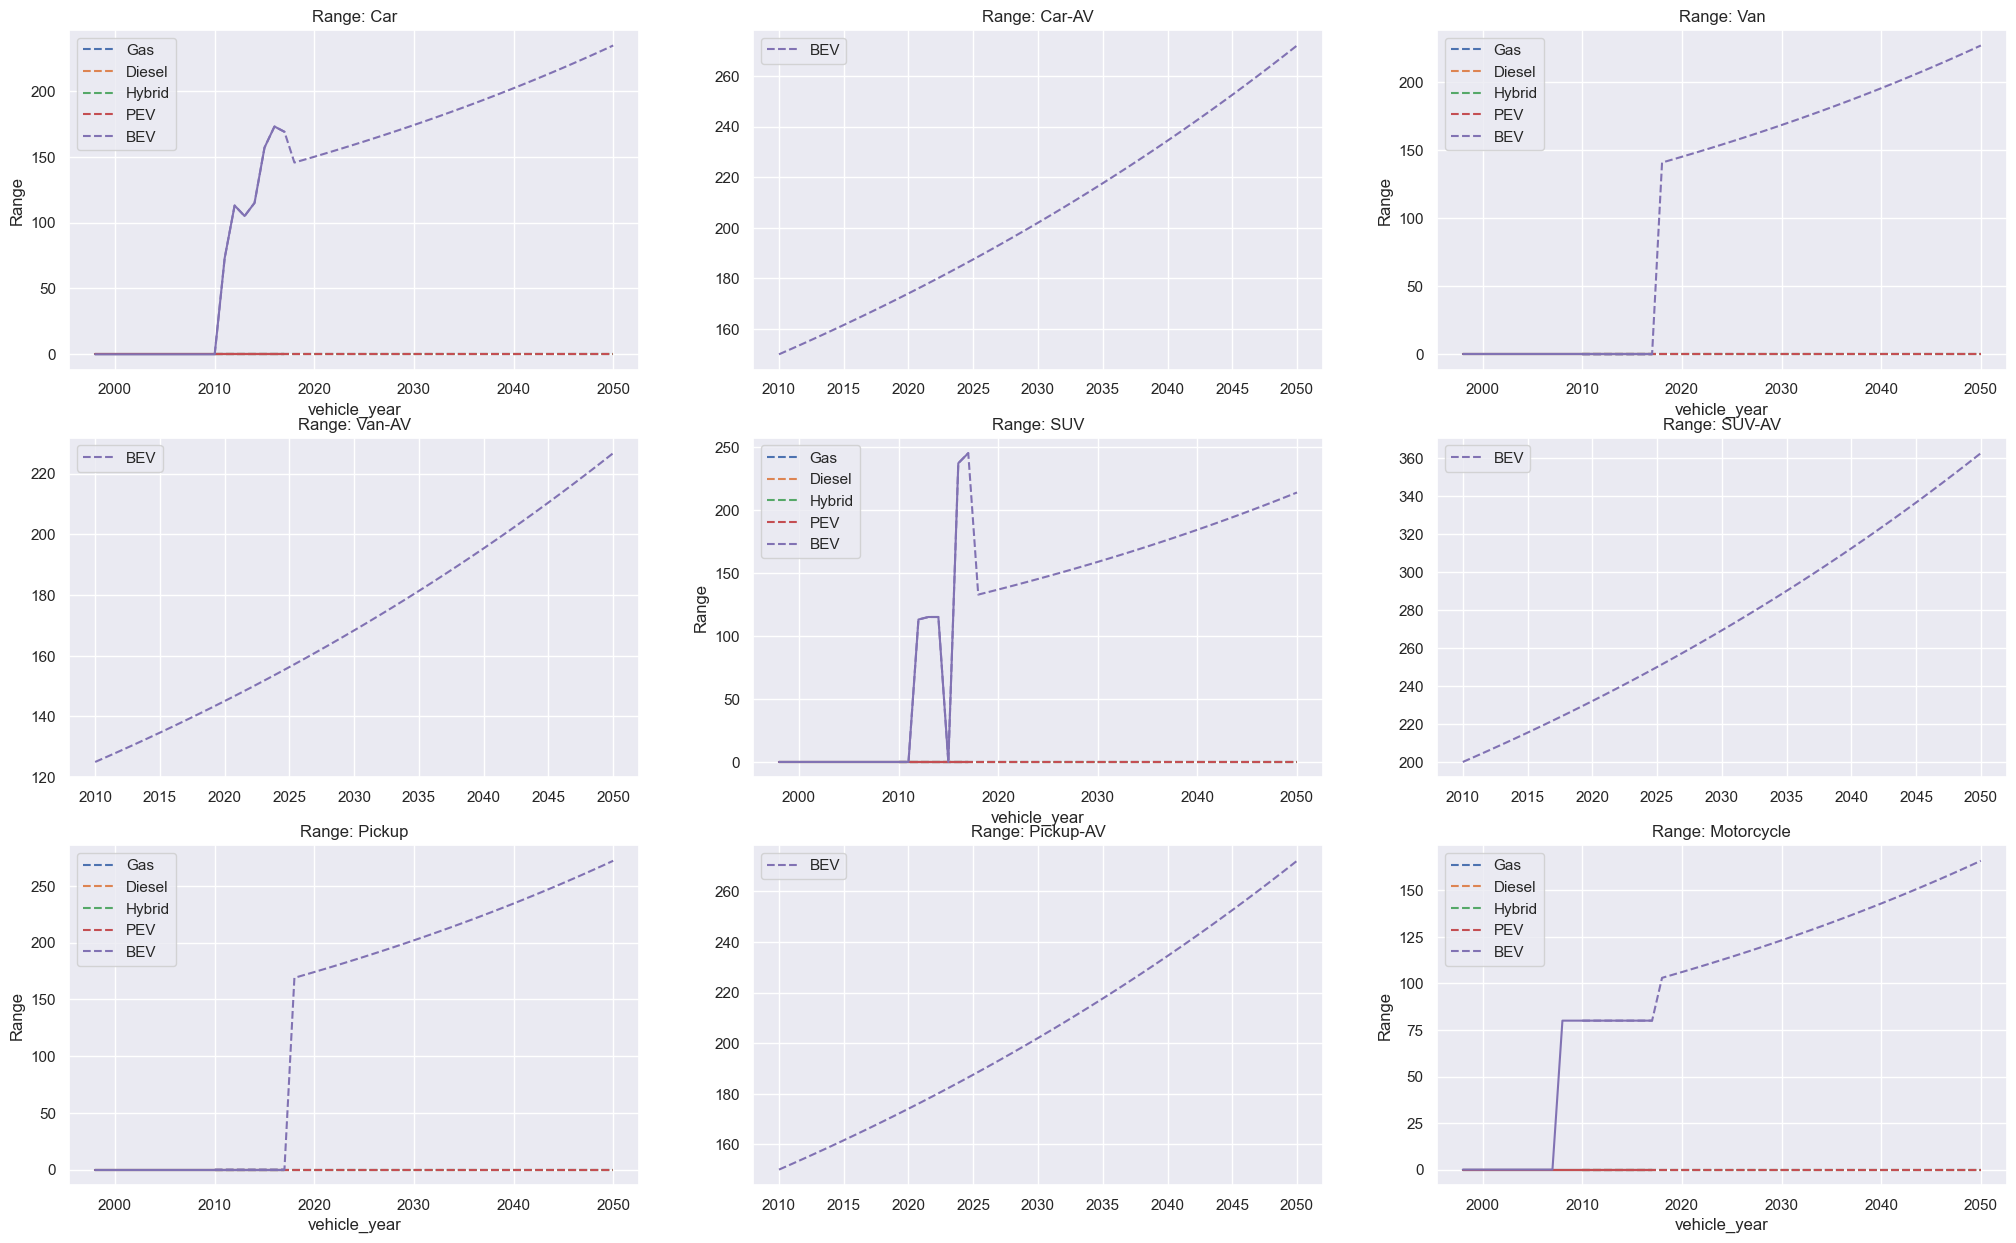

Range for the following alternatives will be set to 0 for all years:
 ['Car-AV_Gas', 'Car-AV_Diesel', 'Car-AV_Hybrid', 'Car-AV_PEV', 'Van-AV_Gas', 'Van-AV_Diesel', 'Van-AV_Hybrid', 'Van-AV_PEV', 'SUV-AV_Gas', 'SUV-AV_Diesel', 'SUV-AV_Hybrid', 'SUV-AV_PEV', 'Pickup-AV_Gas', 'Pickup-AV_Diesel', 'Pickup-AV_Hybrid', 'Pickup-AV_PEV']
Extrapolating Variable: NewPrice


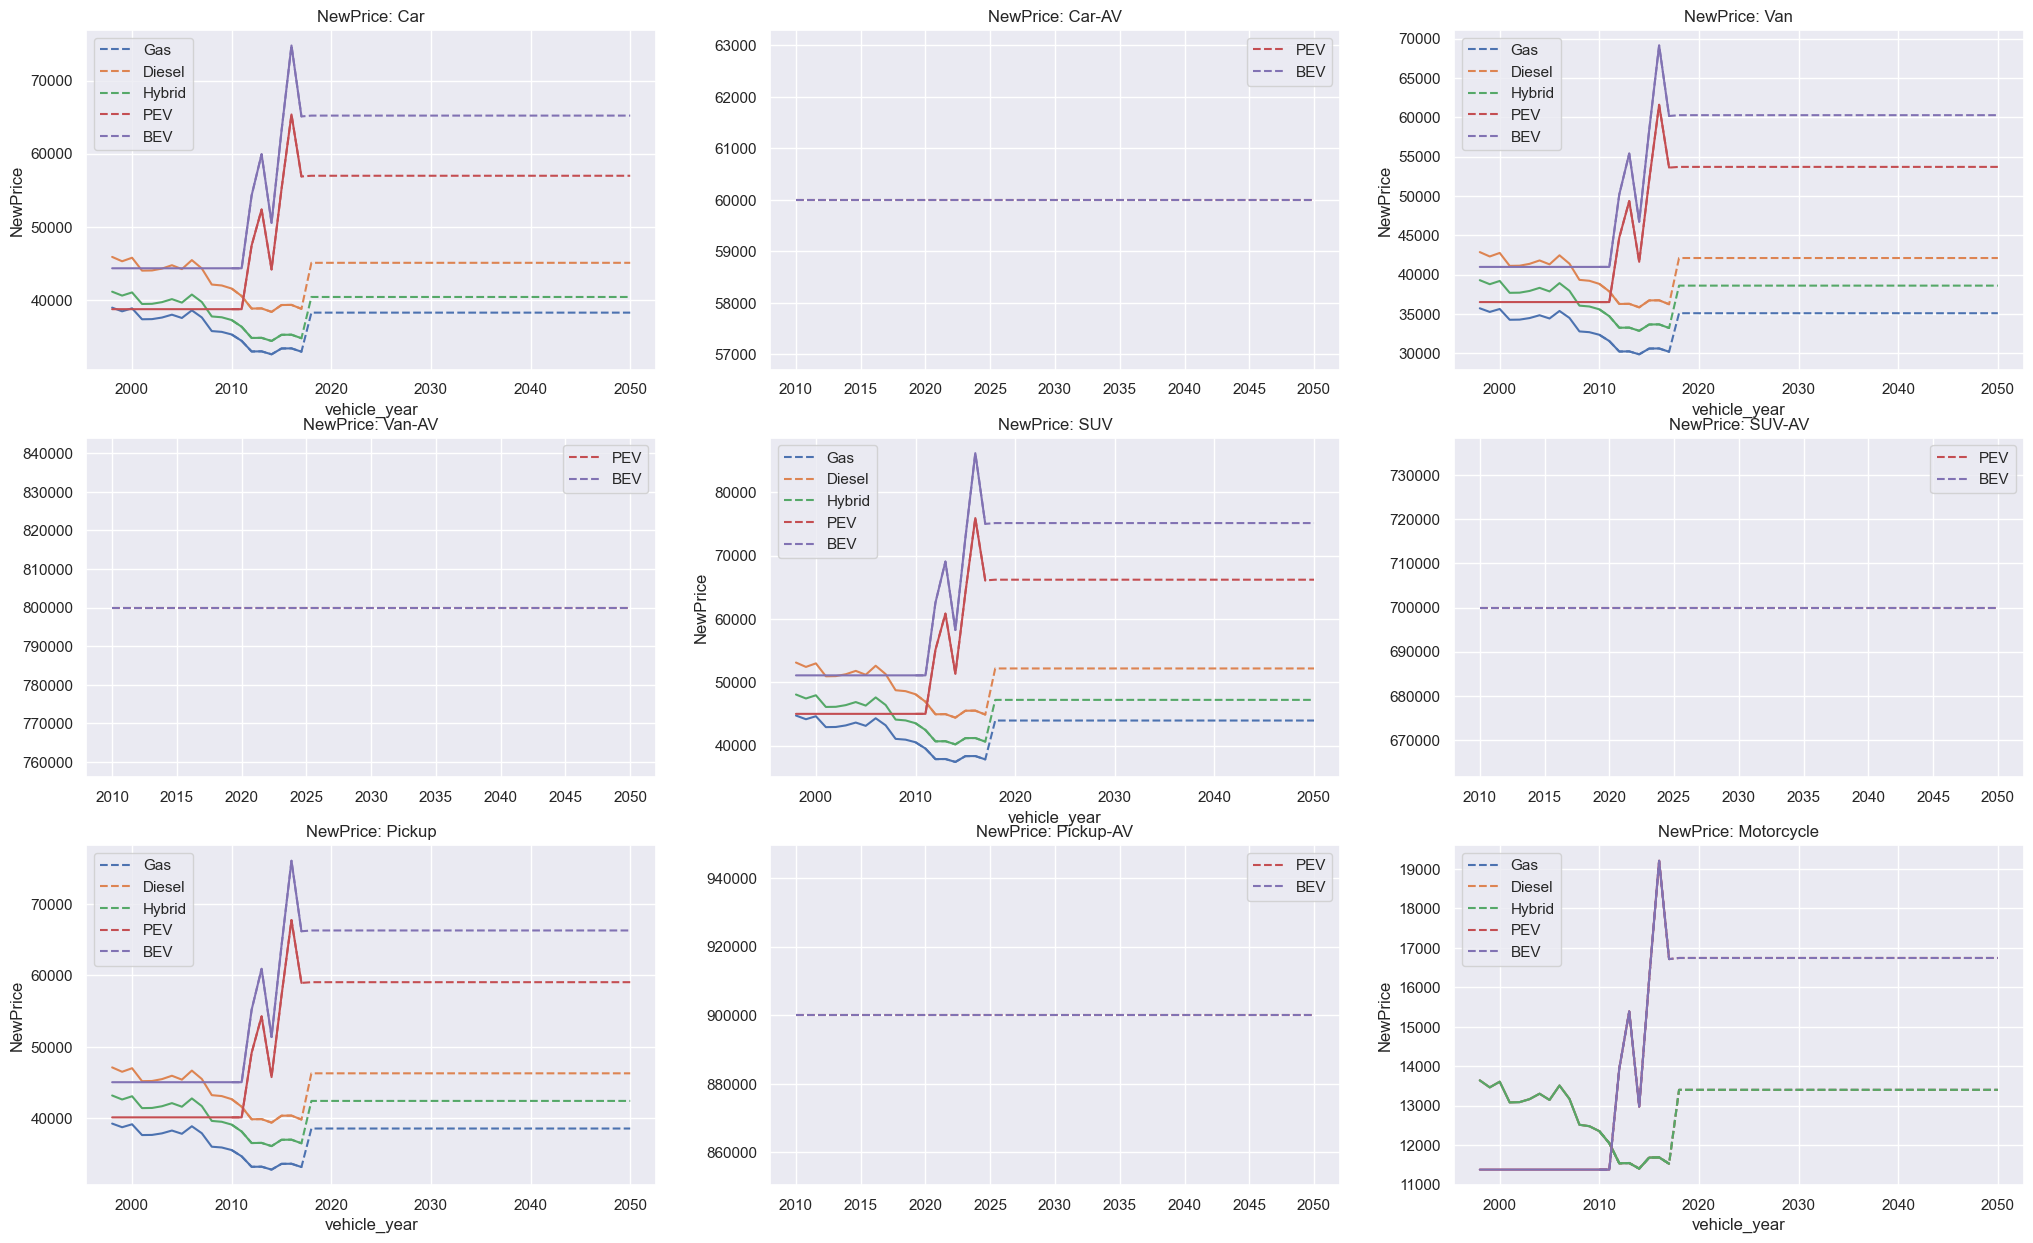

NewPrice for the following alternatives will be set to 0 for all years:
 ['Car-AV_Gas', 'Car-AV_Diesel', 'Car-AV_Hybrid', 'Van-AV_Gas', 'Van-AV_Diesel', 'Van-AV_Hybrid', 'SUV-AV_Gas', 'SUV-AV_Diesel', 'SUV-AV_Hybrid', 'Pickup-AV_Gas', 'Pickup-AV_Diesel', 'Pickup-AV_Hybrid']
Extrapolating Variable: auto_operating_cost


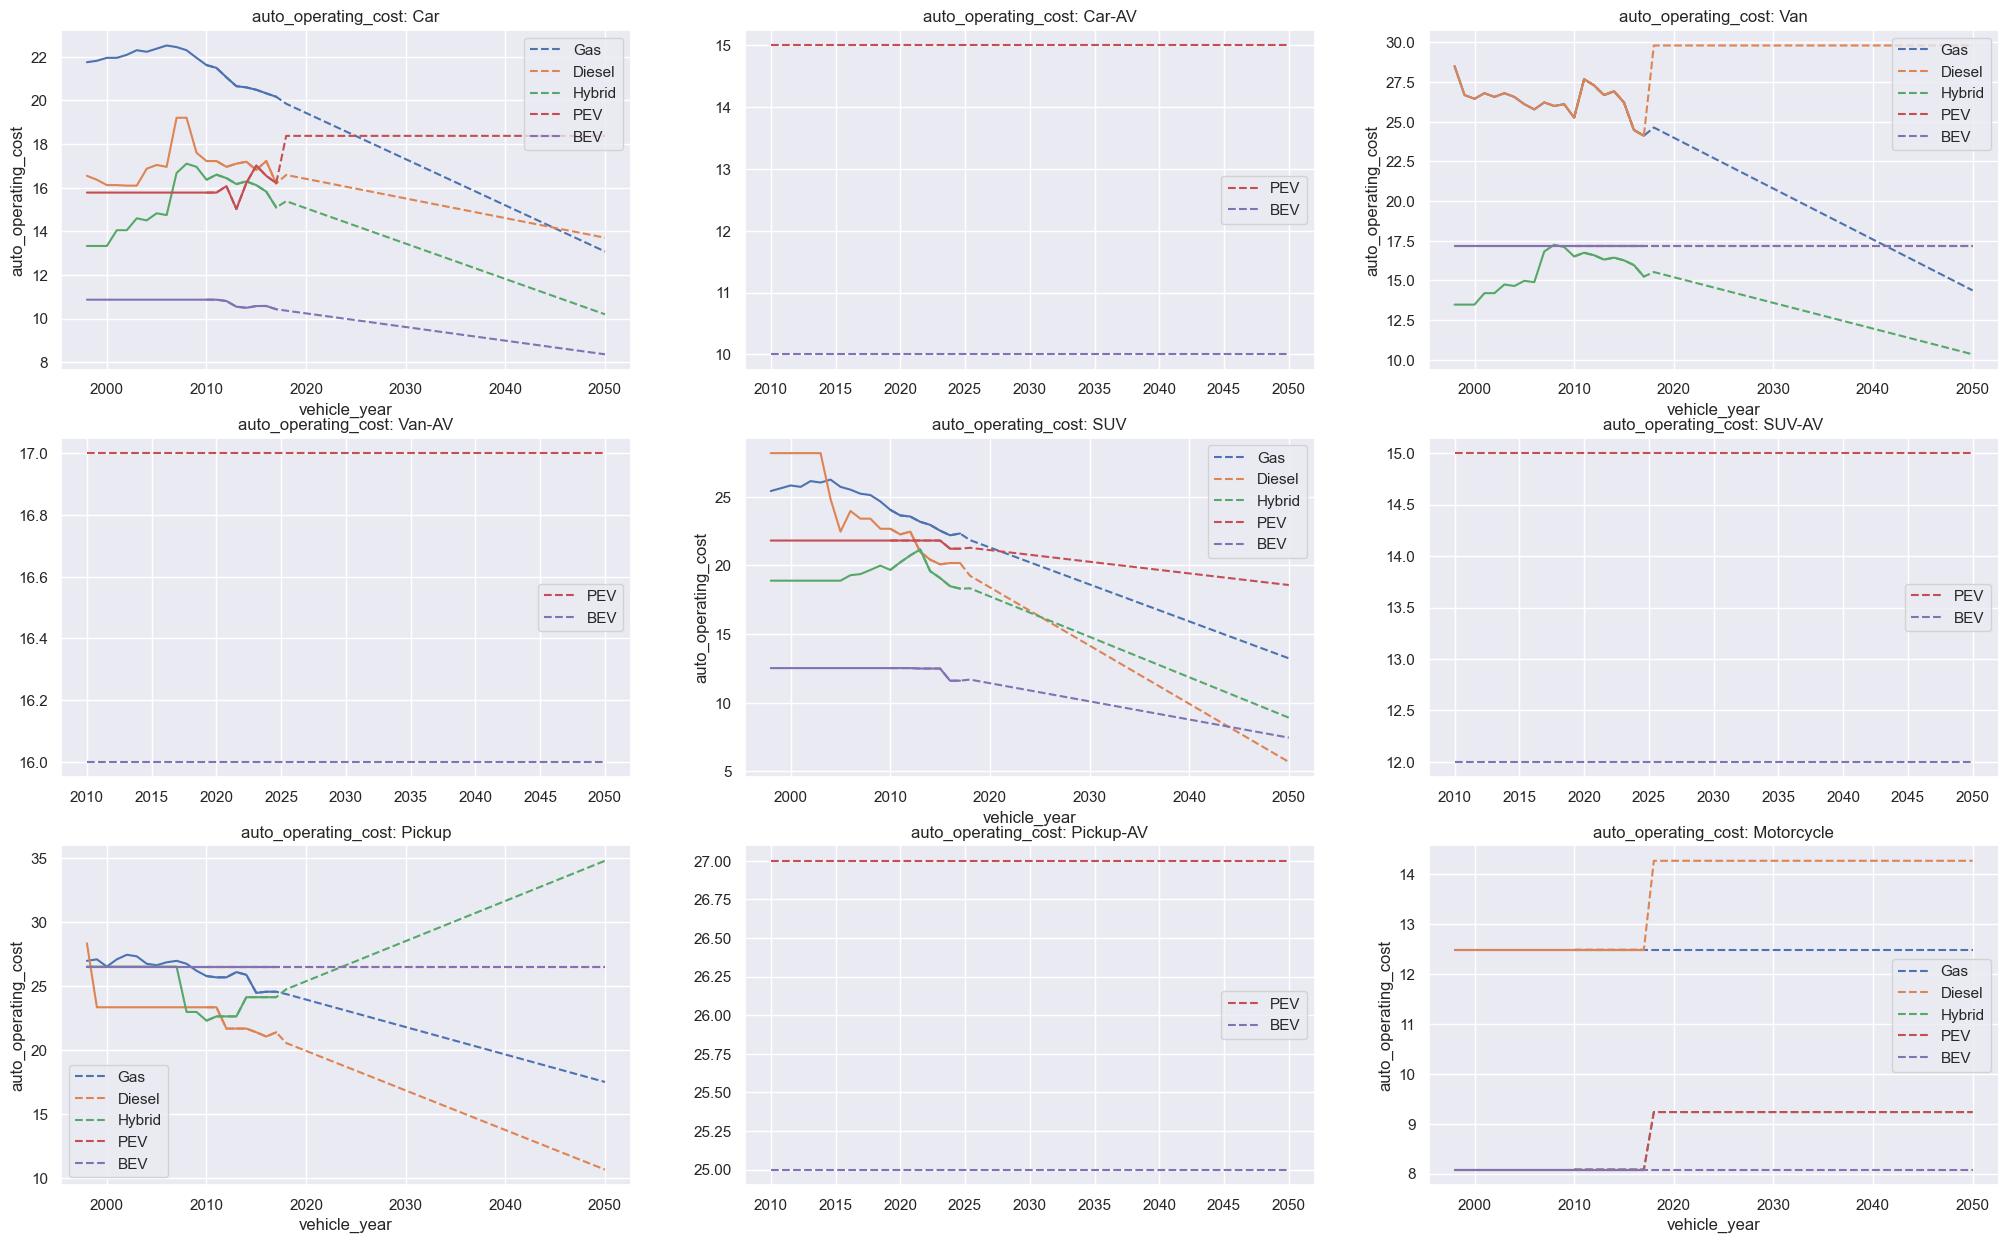

auto_operating_cost for the following alternatives will be set to 0 for all years:
 ['Car-AV_Gas', 'Car-AV_Diesel', 'Car-AV_Hybrid', 'Van-AV_Gas', 'Van-AV_Diesel', 'Van-AV_Hybrid', 'SUV-AV_Gas', 'SUV-AV_Diesel', 'SUV-AV_Hybrid', 'Pickup-AV_Gas', 'Pickup-AV_Diesel', 'Pickup-AV_Hybrid']


In [20]:
old_veh_data, ext_veh_type_data = extrapolate_vehicle_type_data(
    vehicle_type_data_file,
    extrapolation_yaml_file
)

In [29]:
full_veh_data = old_veh_data.set_index(['body_type', 'fuel_type', 'vehicle_year']).combine_first(ext_veh_type_data)
full_veh_data = full_veh_data[(full_veh_data['NumModels'] > 0) & (full_veh_data['NumMakes'] > 0)]
full_veh_data

MPG      NewPrice  NumMakes  \
body_type fuel_type vehicle_year                                       
Car       BEV       2011           93.800000   44331.89559       3.0   
                    2012           95.600000   54291.33743       5.0   
                    2013          104.300000   59928.48966       9.0   
                    2014          106.100000   50547.30465      10.0   
                    2015          103.200000   63109.22167      10.0   
...                                      ...           ...       ...   
Van-AV    PEV       2046           51.274186  800000.00000       2.6   
                    2047           52.043299  800000.00000       2.7   
                    2048           52.823948  800000.00000       2.8   
                    2049           53.616308  800000.00000       2.9   
                    2050           54.420552  800000.00000       3.0   

                                  NumModels  Range  auto_operating_cost  \
body_type fuel_type vehicle_year                                          
Car       BEV       2011               4.00   73.0            10.868294   
                    2012               5.00  113.0            10.808075   
                    2013              12.00  105.0            10.546318   
                    2014              13.00  115.0            10.497521   
                    2015              18.00  157.0            10.576977   
...                                     ...    ...                  ...   
Van-AV    PEV       2046               3.40    0.0            17.000000   
                    2047               3.55    0.0            17.000000   
                    2048               3.70    0.0            17.000000   
                    2049               3.85    0.0            17.000000   
                    2050               4.00    0.0            17.000000   

                                  co2gpm  
body_type fuel_type vehicle_year          
Car       BEV       2011             0.0  
                    2012             0.0  
                    2013             0.0  
                    2014             0.0  
                    2015             0.0  
...                                  ...  
Van-AV    PEV       2046             NaN  
                    2047             NaN  
                    2048             NaN  
                    2049             NaN  
                    2050             NaN  

[1115 rows x 7 columns]

In [30]:
full_veh_data.to_csv(os.path.join(configs_dir, 'vehicle_type_data_extended.csv'))